In [29]:
%matplotlib inline

from IPython import display

import os
import sys
import imp

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from numba.decorators import jit, autojit

import climatools.aerosol.aerowateruptake as aerowateruptake
import climatools.aerosol.aerosol as climaaerosol
import climatools.io.cesm as climaio
import climatools.rrtmg as climarrtmg

imp.reload(climaaerosol)
imp.reload(climaio)
imp.reload(climarrtmg)

<module 'climatools.rrtmg' (namespace)>

In [33]:
# load a CAM history file from some previous global run
filedir = '/nuwa_cluster/home/jackyu/climatools/climatools/aerosol'
filepath = os.path.join(filedir, 'f19_g16.B1850.std.cam2.h0.0001-06.nc')
ds = climaio.load_camhistory(readfrom=filepath)

In [77]:
ILON, ILAT = 70, 90
ITIME = 0

In [55]:
LON, LAT = ds['lon'][ILON].values, ds['lat'][ILAT].values
TIME = ds['time'][ITIME].values

### timeit: aerowateruptake.modal_aer_wateruptake_sub()

In [270]:
pcols, pver, ntot_amode, max_nspec_amode = 1, 30, 3, 6
args_isel = {'time':ITIME, 'lon':ILON, 'lat':ILAT}
modes = [1, 2, 3]

try:
    relative_humidity = ds['RELHUM'].isel(**args_isel)
    cloud_fraction = ds['CLOUD'].isel(**args_isel)
    species_mmr = climaaerosol.get_raer(ds, **args_isel)
    
    relative_humidity = relative_humidity.values.reshape((pcols, pver))
    cloud_fraction = cloud_fraction.values.reshape((pcols, pver))
except KeyError as e:
    print('Needed variables missing from CAM history.')
    raise e

In [277]:
%timeit aerowateruptake.modal_aero_wateruptake_sub(pcols=1,\
            cldn=cloud_fraction,\
            relative_humidity=relative_humidity,\
            raer=species_mmr)

The slowest run took 239.41 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 103 µs per loop


In [278]:
def runthis():
    for _ in range(2):
        for _ in range(3):
            aerowateruptake.modal_aero_wateruptake_sub(pcols=1,\
            cldn=cloud_fraction,\
            relative_humidity=relative_humidity,\
            raer=species_mmr)
            
%timeit runthis()

1000 loops, best of 3: 622 µs per loop


In [279]:
@jit(nopython=True)
def runthis():
    for _ in range(2):
        for _ in range(3):
            aerowateruptake.modal_aero_wateruptake_sub(pcols=1,\
            cldn=cloud_fraction,\
            relative_humidity=relative_humidity,\
            raer=species_mmr)
            
%timeit runthis()

UntypedAttributeError: Failed at nopython (nopython frontend)
Unknown attribute "modal_aero_wateruptake_sub" of type Module(<module 'climatools.aerosol.aerowateruptake' from '/nuwa_cluster/home/jackyu/climatools/climatools/aerosol/aerowateruptake.cpython-34m.so'>)
File "<ipython-input-279-d46a00c14cf9>", line 5

### timeit: get_aer()

In [37]:
%timeit climaaerosol.get_raer_column(ds)

10 loops, best of 3: 19.4 ms per loop


### timeit: climaaerosol.wateruptake_column()

In [280]:
%timeit climaaerosol.wateruptake_column(ds, ilon=ILON, ilat=ILAT)

The slowest run took 7.23 times longer than the fastest. This could mean that an intermediate result is being cached 
100 loops, best of 3: 9.19 ms per loop


In [281]:
def runthis():
    for _ in range(2):
        for _ in range(3):
            climaaerosol.wateruptake_column(ds, ilon=ILON, ilat=ILAT)
            
%timeit runthis()

10 loops, best of 3: 55.5 ms per loop


In [269]:
@jit(nopython=True)
def runthis():
    for _ in range(2):
        for _ in range(3):
            climaaerosol.wateruptake_column(ds, ilon=ILON, ilat=ILAT)
            
%timeit runthis()

TypeError: Failed at nopython (nopython frontend)
unhashable type: 'Dataset'

### timeit: climaaerosol.wateruptake_column() inside loops

In [282]:

def runthis():
    for _ in range(96):
        for _ in range(180):
            climaaerosol.wateruptake_column(ds, ilon=ILON, ilat=ILAT)    
            
%timeit runthis()

1 loops, best of 3: 2min 40s per loop


# Loop over time, latitude and longitude in Fortran

In [397]:
aerowateruptake.modal_aero_wateruptake_sub?

### Fake cloud fraction, relative humidity and species mass mixing ratio
    
Note the speed up.

In [350]:
def madeup_wateruptake_input():
    pcols = 2
    
    pver, nmode, max_nspecies = 30, 3, 6
    
    cldn1 = np.random.randn(pver)
    rh1 = np.random.randn(pver)
    raer1 = np.random.randn(pver, nmode, max_nspecies)
    
    cldn2 = np.random.randn(pver)
    rh2 = np.random.randn(pver)
    raer2 = np.random.randn(pver, nmode, max_nspecies)
    
    cldn = np.array([cldn1, cldn2])
    rh = np.array([rh1, rh2])
    raer = np.array([raer1, raer2])
    return cldn, rh, raer


def madeup_wateruptake_input_pcols(pcols=2):
    pver, nmode, max_nspecies = 30, 3, 6
    
    cldn = np.random.randn(pcols, pver)
    rh = np.random.randn(pcols, pver)
    raer = np.random.randn(pcols, pver, nmode, max_nspecies)
    return cldn, rh, raer

In [356]:
cldn, rh, raer = madeup_wateruptake_input_pcols(pcols=96*180)



In [358]:
%timeit aerowateruptake.modal_aero_wateruptake_sub(pcols=96*180, cldn=cldn, relative_humidity=rh, raer=raer)

1 loops, best of 3: 17.8 s per loop


### Using real cloud fraction, relative humidity and species mass mixing-ratio



In [329]:
aeroconst.MAM3_SPECIES

{1: {1: 'sulfate',
  2: 'p-organic',
  3: 's-organic',
  4: 'black-c',
  5: 'dust',
  6: 'seasalt'},
 2: {1: 'sulfate', 2: 's-organic', 3: 'seasalt'},
 3: {1: 'dust', 2: 'seasalt', 3: 'sulfate'}}

In [41]:
%timeit climaaerosol.aerosol_species_mmr(ds)

1 loops, best of 3: 399 ms per loop


In [42]:
%timeit climaaerosol.wateruptake(ds)

1 loops, best of 3: 1.71 s per loop


In [40]:
%%timeit

import climatools.aerosol.aerosol as climaaerosol

# load a CAM history file from some previous global run
filedir = '/nuwa_cluster/home/jackyu/climatools/climatools/aerosol'
filepath = os.path.join(filedir, 'f19_g16.B1850.std.cam2.h0.0001-06.nc')
ds = climaio.load_camhistory(readfrom=filepath)

# group together aerosol species mass mixing-ratios
ds = climaaerosol.aerosol_species_mmr(ds)

# wateruptake. compute qaerwat, dgncur_awet and wetdens
ds = climaaerosol.wateruptake(ds)

1 loops, best of 3: 2.72 s per loop


## Results

In [17]:
filepath = os.path.join('/nuwa_cluster/home/jackyu/radiation',
                        'radiation_notebooks/rrtmg_aerosol',
                        'f19_g16.B1850.std.cam2.h0.0001-06.nc')

ds = climaio.load_camhistory(readfrom=filepath)


In [18]:
ds = climaaerosol.aerosol_species_mmr(ds)

mode, species, name, name_mmr: 1 1 sulfate so4_a1
mode, species, name, name_mmr: 1 2 p-organic pom_a1
mode, species, name, name_mmr: 1 3 s-organic soa_a1
mode, species, name, name_mmr: 1 4 black-c bc_a1
mode, species, name, name_mmr: 1 5 dust dst_a1
mode, species, name, name_mmr: 1 6 seasalt ncl_a1
mode, species, name, name_mmr: 2 1 sulfate so4_a2
mode, species, name, name_mmr: 2 2 s-organic soa_a2
mode, species, name, name_mmr: 2 3 seasalt ncl_a2
mode, species, name, name_mmr: 3 1 dust dst_a3
mode, species, name, name_mmr: 3 2 seasalt ncl_a3
mode, species, name, name_mmr: 3 3 sulfate so4_a3


In [19]:
ds = climaaerosol.wateruptake(ds)

### DGNCUR_AWET

/nuwa_cluster/home/jackyu/locally_installed_python_pacakges/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


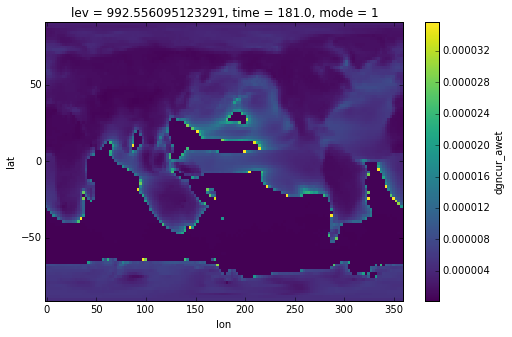

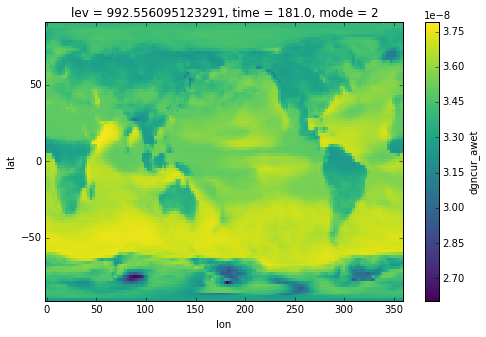

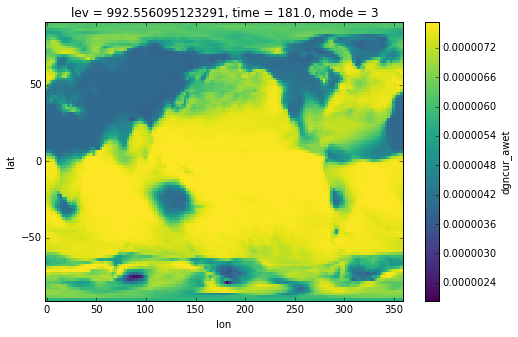

In [42]:
variable = 'dgncur_awet'

da = ds[variable]

# look at lowest layer
index_time, index_lev = 0, ds.dims['lev'] - 1

for mode in da.coords['mode']:
    fig, ax = plt.subplots(figsize=(8, 5))
    da.isel(time=index_time, lev=index_lev)\
      .sel(mode=mode).plot(ax=ax)
            
    display.display(plt.gcf())
    plt.close()

### QAERWAT

/nuwa_cluster/home/jackyu/locally_installed_python_pacakges/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


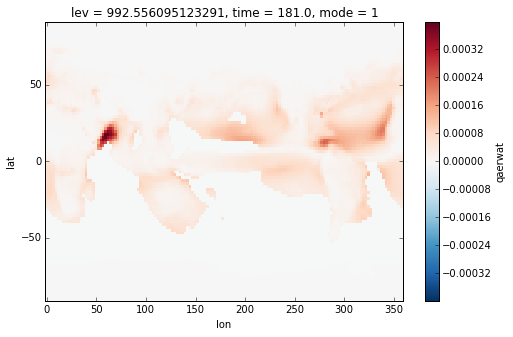

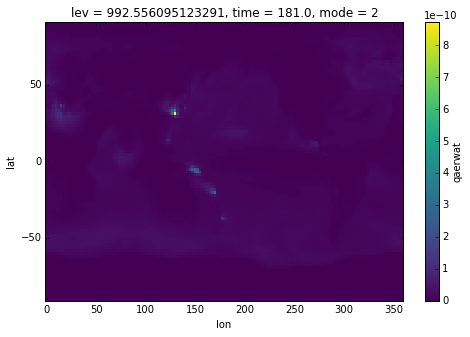

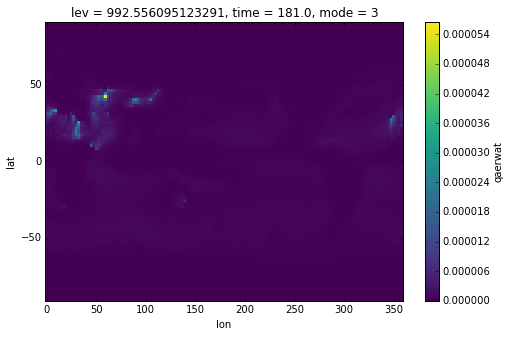

In [40]:
variable = 'qaerwat'

da = ds[variable]

# look at lowest layer
index_time, index_lev = 0, ds.dims['lev'] - 1

for mode in da.coords['mode']:
     fig, ax = plt.subplots(figsize=(8, 5))
     da.isel(time=index_time, lev=index_lev)\
       .sel(mode=mode).plot(ax=ax)
            
     display.display(plt.gcf())
     plt.close()

### WETDENS

/nuwa_cluster/home/jackyu/locally_installed_python_pacakges/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


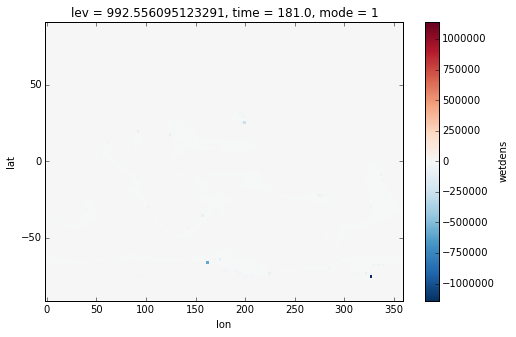

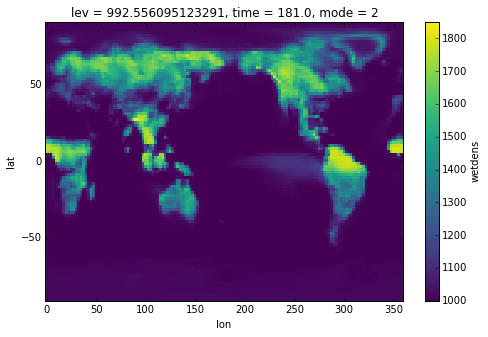

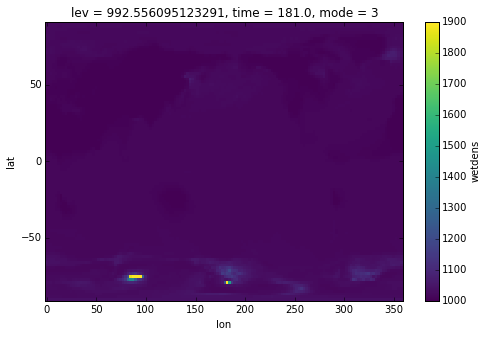

In [43]:
variable = 'wetdens'

da = ds[variable]

# look at lowest layer
index_time, index_lev = 0, ds.dims['lev'] - 1

for mode in da.coords['mode']:
     fig, ax = plt.subplots(figsize=(8, 5))
     da.isel(time=index_time, lev=index_lev)\
       .sel(mode=mode).plot(ax=ax)
            
     display.display(plt.gcf())
     plt.close()

In [44]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')